# **Metody interpretacji sieci neuronowych**

## Wprowadzenie
Ogólna zasada jest taka, że im bardziej skomplikowana sieć (model), tym bardziej złożone problemy potrafi opisać (co jest dość intuicyjne). Wiąże się z tym pewna komplikacja w postaci utraty interpretowalności wraz ze wzrastającym poziomem złożoności modelu.

### Po co w ogóle się przejmować interpretowalnością?

* ulepszanie modelu -> gdy przeanalizujemy na co zwraca uwagę podczas klasyfikacji i regresji, i dowiemy się, że skupia się na niezbyt istotnej cesze, możemy spróbować ulepszyć model. Przykład: **[obraz](http://3.bp.blogspot.com/-S8g8SNWhyR0/WIsOFqPD2WI/AAAAAAAAA68/9yNFp6sdao0Er7qDIqEPu7ORTU589tFCACK4B/s1600/Bildschirmfoto%2B2017-01-27%2Bum%2B10.08.11.png): pies husky na śniegu => predykcja: wilk**


* powody etyczne: zapobieganie dyskryminacji wdrukowanej przez człowieka opisującego dane treningowe oraz modele stosowane do celów medycznych
* powody prawne: od maja 2019 r. każdy obywatel Unii ma prawo poznać rozumowanie stojące za każdą zautomatyzowaną, dotyczącą go decyzją
* jedyny sposób, żeby uczenie maszynowe nauczyło nas czegoś nowego o fizyce?

Przykłady interpretowalnych modeli, które poznaliśmy na zajęciach: *uzupełnij*

Sztandarowym przykładem bogatego modelu nieinterpretowalnego są głębokie sieci neuronowe (w tym konwolucyjne, szczególnie skuteczne w analizie obrazków).

Notebook oparty na tutorialu:
* [Class Activation Map in Keras](https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb)

## Jakie mamy metody?

Baaaaaardzo dużo. W ogólności można je podzielić na trzy kategorie (choć nie wyczerpuje to tematu! Dziedzina interpretowalnego uczenia maszynowego produkuje kilka nowych metod co tydzień!).

Można zadać sobie następujące pytania:
1. Jaki input, jakie dane wejściowe maksymalnie aktywują neuron odpowiadający predykcji konkretnej klasy? Czyli jak wygląda według modelu archetypowy pies/kot/dziewiątka? Przykłady: [wizualizacja cech (feature visualisation)](https://storage.googleapis.com/lucid-static/feature-visualization/4.png), zainteresowani mogą wygooglować DeepDream
2. Czy możemy lokalnie zastąpić ten model prostszym, za to interpretowalnym? Przykłady: [LIME](https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b).
3. Która część danych wejściowych (np. która część obrazka) była najbardziej odpowiedzialna za daną predykcję? Przykłady: [mapy ciepła](https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1)

Część takich metod jest zebrana w ładnej bibliotece [iNNvestigate](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/mnist_compare_methods.ipynb).


W ramach dzisiejszych ćwiczeń poznamy i pobawimy się podstawową metodą interpretowalności z kategorii 3, czyli mapami aktywacji klasy (CAM, Class Activation Maps, [publikacja](https://arxiv.org/pdf/1512.04150.pdf)). Mają wiele pochodnych i udoskonaleń (np. [Grad-CAM](https://jacobgil.github.io/deeplearning/class-activation-maps)), zbiorczo takie mapy nazywa się czasem mapami ciepła.



![CAM](https://drive.google.com/uc?id=1vibsld9iq7j4GYgDP5LMXdoitvfr8q_M)

## Zaczniemy od importu wytrenowanej i skomplikowanej sieci [VGG16](https://neurohive.io/en/popular-networks/vgg16/)

Żeby było więcej zabawy, będziemy dzisiaj sprawdzać mapy ciepła na obrazkach ze zbioru ImageNet. To zbiór ponad 14 milionów zdjęć z [1000](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) kategorii (a dokładniej z 1000 nienachodzących na siebie kategorii, generalnie wylicza się tam 20 000 kategorii, ale wyścigi sieci neuronowych robi się na tych rozłącznych).

Zaprojektowanie od zera skutecznej sieci rozpoznającej tyle obiektów byłoby trudne i czasochłonne (głównie czasochłonne), więc stańmy na ramionach olbrzymów :)

In [0]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

Using TensorFlow backend.





553467904/553467096 [==============================] - 15s 0us/step








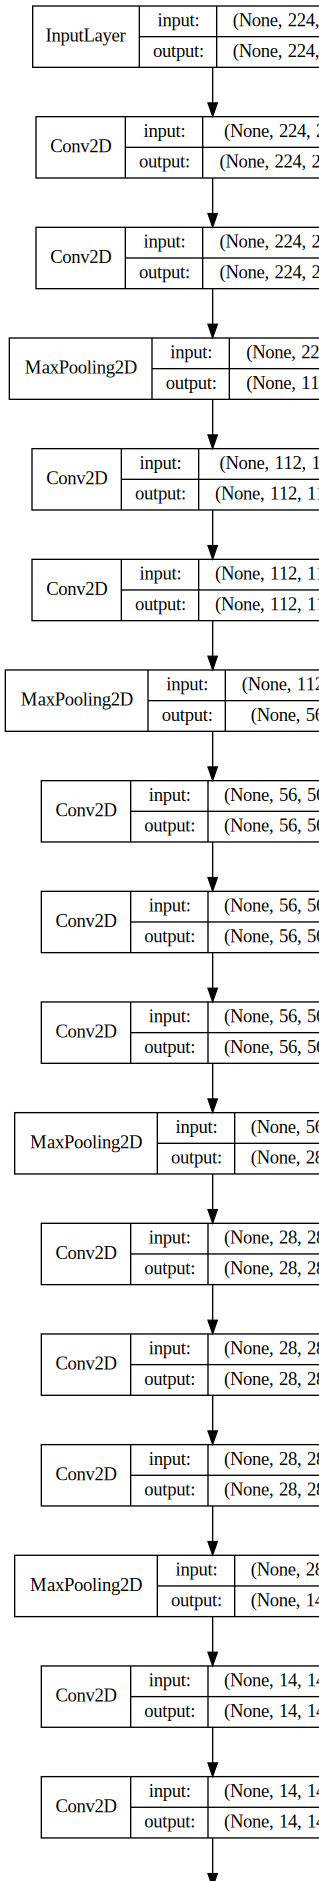

In [0]:
model = VGG16(weights='imagenet')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
tmp = model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg') #, dpi=65
SVG(tmp)

In [0]:
# Podłączmy dysk, żeby móc pytać sieć o predykcje dla dowolnych obrazków

from google.colab import drive
drive.mount('/content/drive/')
folder = '/content/drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


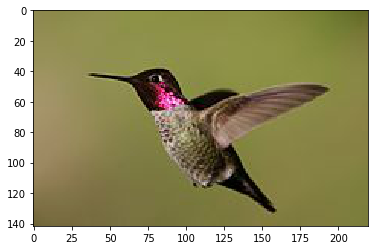

In [0]:
img_path = folder + 'hummingbird.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)

In [0]:
# Zmieniamy rozmiar obrazka, aby pasował do inputu sieci VGG
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224))

# Konwertujemy do numpy array'a
x = image.img_to_array(img)

# A następnie zmnieniamy ponownie kształt obrazka, tak any był w formie "batcha"
import numpy as np
x = np.expand_dims(x, axis=0)

print(x.shape)

In [0]:
# Jako że używamy gotowych wytrenowanych wag, które były uzyskiwane na odpowiednio przeprocesowanych obrazkach (m.in. w specyficzny sposób normalizowane),
# to aby móc używać ich na nowych obrazkach, musimy je w identyczny sposób przeprocesować.
from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)
print(x)

In [0]:
# W ten sposób możemy uzyskać predykcje sieci na obrazku. Jako że sieć rozpoznaje aż 1000 klas, to warto użyć pandas, aby opanować tę ilość danych.
import pandas as pd
from keras.applications.vgg16 import decode_predictions
preds = model.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
print('Predykcja:',predictions.loc[0,'category'])

In [0]:
# Zróbmy wykres "pewności" maszyny, że obiekt z obrazka należy do jednej z trzech topowych kategorii:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 predykcje:')

In [0]:
# Indeks predykcji
argmax = np.argmax(preds[0])
output = model.output[:, argmax]

In [0]:
# Potrzebujemy ostatniej warstwy konwolucyjnej
last_conv_layer = model.get_layer('block5_conv3') # znamy jej nazwę z opisu modelu ogólnie dostępnego

In [0]:
# Liczymy gradient
grads = K.gradients(output, last_conv_layer.output)[0]

In [0]:
# Każdy element tego tensora gradientu to średnia intensywność gradientu w konkretnej mapie aktywacji i ma kształt (512,)
# co można sprawdzić z architektury
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [0]:
# Tworzymy funkcję, która nam zwraca uśrednione gradienty z ostatniej warstwy konwolucyjnej dla odpowiedniego inputu
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

In [0]:
# Robimy pętlę iterującą po każdym kanale mapy aktywacji i mnożymy każdy z nich przez wagę odpowiadającą jak ważny jest ten kanał co wynika z wartości uśrednionego gradientu dla tego kanału
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
# Tworzymy mapę ciepła!
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [0]:
# Użyjemy biblioteki OpenCV do łączenia dotychczasowego obrazka i mapy ciepła
import cv2
img = cv2.imread(img_path)

In [0]:
# Dopasowywujemy mapę ciepła, aby pasowała do naszego obrazka
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Przechodzimy z nią do RGB
heatmap = np.uint8(255 * heatmap)

# Łączymy z naszym obrazkiem
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Nakładamy na oryginalny obrazek z wybraną intensywnością
intensity = 0.8
superimposed_img = heatmap * intensity + img

Text(0.5, 1.0, 'hummingbird')

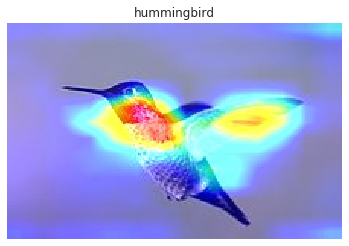

In [0]:
out_path = folder + 'CAM_hummingbird.jpg'
cv2.imwrite(out_path, superimposed_img)

img = mpimg.imread(out_path)

plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

## Zadania na dzisiaj ##
1. Metodą "kopiuj-wklej" stwórz funkcję, która za argument przyjmuje ścieżkę do obrazka z dysku, a zwraca mapę aktywacji odpowiedniej klasy.
2. Zastosuj do kilku obrazków z internetu i zastanów się, co mapy mówią Ci o odpowiednich predykcjach sieci VGG16.
3. Zastosuj do kilku obrazków z internetu z tej samej kategorii (np. różne psy, różne koty) i znów zastanów się, co mapy mówią Ci o odpowiednich predykcjach sieci VGG16.

1. Obrazki z interetu. Zbadano: człowieka w restauracji, krzesło stojące o nietrywialnym kształcie, rękę człowieka, samolot pasażerksi, śrubokręt. Sieć zwróciła: restaurację, fotel bujany, pędzel, samolot pasażerski, śrubokręt. Predykcja następowała na podstawie dość wąskiego, gorącego obszaru, który był charakterystyczny dla typu danej rzeczy: np. dla samolotu była to środkowa sekcja, przy skrzydłach a dla śrobokrętu był to charakterystyczny fragment łączący uchwyt z prętem.
2. Zdjęcia różnych ras psów (4 rasy) i kotów (3 rasy). Sieć radziła sobie bardzo dobrze z rozpoznawaniem ras. Predykcja następowała na podstawie  (zwykle, choć nie zawsze!) dość wąskiego, gorącego obszaru. Był to obszar nosa z okolicami, uszu bądź tułowia przy czym czasem były to tylko uszy, czasem tylko okolice nosa a czasem wpływ miał np. tylko tułów. Zależy to prawdopodobnie od tego jaka część psa/kota jest najbardziej charakterystyczna dla danej rasy np. czy szpiczaste uszy, obecność centków itp.
3. Podsumowując: sieć jest dość mocno wyspecjalizowana np. zdolność rozróżniania ras psów i kotów jest moim zdaniem na poziomie przeciętnego człowieka (lub nawet lepszym). Z kolei sieć miała problem z trywialnym dla człowieka problemem rozpoznania ludzkiej ręki czy też określenia czy fotel jest bujany czy też nie (sieć użyła jedynie części dostępnej informacji - zakrzywienia oparcia a obecność nietrywialnych nóżek została zignorowana w sensie mapy ciepła). Nawet jeśli sieć potrafi rozpoznać człowieka jako całość to ma problem z rozpoznawaniem poszczególnych elementów, np. ręki. Widać więc (co skądinąd wiaodmo), że sieć "nie rozumie" czym jest człowiek w sensie abstrakcynym - potrafi jedynie rozpoznawać pewne charakterystyczne detale rzeczy co jest użyteczne np. w rozpoznawaniu podobnych obiektów  np. ras kotów.

Predykcja: restaurant


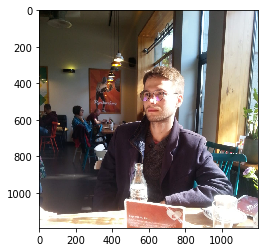

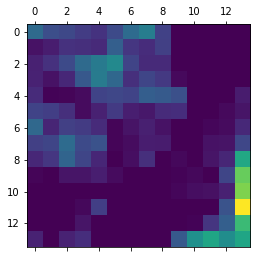

Text(0.5, 1.0, 'restaurant')

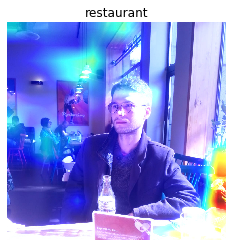

In [27]:
def heatMap(img_path):

  from keras.preprocessing import image
  from keras.applications.vgg16 import preprocess_input
  from keras.applications.vgg16 import decode_predictions
  import numpy as np
  import pandas as pd
  import cv2

  img = mpimg.imread(img_path)
  plt.imshow(img)

  # Zmieniamy rozmiar obrazka, aby pasował do inputu sieci VGG
  
  img = image.load_img(img_path, target_size=(224, 224))

  # Konwertujemy do numpy array'a
  x = image.img_to_array(img)

  # A następnie zmnieniamy ponownie kształt obrazka, tak any był w formie "batcha"
 
  x = np.expand_dims(x, axis=0)

  
  x = preprocess_input(x)


 
  preds = model.predict(x)
  predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
  print('Predykcja:',predictions.loc[0,'category'])

  # Indeks predykcji
  argmax = np.argmax(preds[0])
  output = model.output[:, argmax]

  # Potrzebujemy ostatniej warstwy konwolucyjnej
  last_conv_layer = model.get_layer('block5_conv3') # znamy jej nazwę z opisu modelu ogólnie dostępnego

  # Liczymy gradient
  grads = K.gradients(output, last_conv_layer.output)[0]

  # Każdy element tego tensora gradientu to średnia intensywność gradientu w konkretnej mapie aktywacji i ma kształt (512,)
  # co można sprawdzić z architektury
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # Tworzymy funkcję, która nam zwraca uśrednione gradienty z ostatniej warstwy konwolucyjnej dla odpowiedniego inputu
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  # Robimy pętlę iterującą po każdym kanale mapy aktywacji i mnożymy każdy z nich przez wagę odpowiadającą jak ważny jest ten kanał co wynika z wartości uśrednionego gradientu dla tego kanału
  for i in range(512):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # Tworzymy mapę ciepła!
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  return heatmap,predictions

import numpy as np
import matplotlib.pyplot as plt

folder = '/content/drive/My Drive/Colab Notebooks/'
filename='misc1.jpg'
img_path = folder + filename

heatmap, predictions =heatMap(img_path)

plt.matshow(heatmap)
plt.show()

img = cv2.imread(img_path)

# Dopasowywujemy mapę ciepła, aby pasowała do naszego obrazka
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Przechodzimy z nią do RGB
heatmap = np.uint8(255 * heatmap)

# Łączymy z naszym obrazkiem
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Nakładamy na oryginalny obrazek z wybraną intensywnością
intensity = 0.8
superimposed_img = heatmap * intensity + img

out_path = folder + 'CAM_'+filename
cv2.imwrite(out_path, superimposed_img)

img = mpimg.imread(out_path)

plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])